<iframe src="https://www.kaggle.com/embed/abdmental01/cat-vs-dog-transfer-learning-0-99?cellIds=3&kernelSessionId=163139148" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Cat Vs Dog | Transfer Learning | 0.99"></iframe>

# **import library**

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

2025-04-27 15:52:58.399070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 15:52:58.399215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 15:52:58.524396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**This code finds pictures of brains with and without tumors in a special folder. It looks inside each folder to find the pictures and labels them as either "yes" (tumor) or "no" (no tumor). Then it organizes all this information into a list that shows which picture belongs to which label.**

In [2]:
# Directory containing the "brain_tumor_dataset" folder
directory = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

# Collect file paths and labels from subfolders
filepaths = []
labels = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepaths.append(img_path)
        labels.append(fold)

# Create DataFrame from collected data
file_path_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
df_train = pd.concat([file_path_series, label_series], axis=1)


In [3]:
# Head
df_train

,filepath,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
248,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
249,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


# **Data Spliting**


**This code splits a dataset (df_train) into three subsets: train_df (80% for training), valid_df (10% for validation), and test_df (10% for testing), ensuring random shuffling and reproducibility with a fixed random seed (42). It prepares the data for training a machine learning model while ensuring separate datasets for validation and final evaluation.**

In [4]:

from sklearn.model_selection import train_test_split

# Spliting in Train and Dummy 
train_df , dummy_df = train_test_split(df_train ,train_size = 0.8 , shuffle = True ,random_state = 42 )
# Spliting in Validation and Test From Dummy 
valid_df , test_df = train_test_split(dummy_df ,test_size= 0.5 , shuffle = True ,random_state = 42)

In [5]:
# Shape
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {valid_df.shape}")
print(f"The shape of The Test data is: {test_df.shape}")

The shape of The Train data is: (202, 2)
The shape of The Validation data is: (25, 2)
The shape of The Test data is: (26, 2)


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator without augmentation
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32


# Flow from dataframe or directory, ensuring binary class_mode
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Training Data
Found 202 validated image filenames belonging to 2 classes.
Validation Data
Found 25 validated image filenames belonging to 2 classes.
Test Data
Found 26 validated image filenames belonging to 2 classes.


In [8]:
# Test the training data generator
print("Testing Training Data Generator")
x_train, y_train = next(iter(train_ds))
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Test the validation data generator
print("Testing Validation Data Generator")
x_valid, y_valid = next(iter(validation_ds))
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")


Testing Training Data Generator
x_train shape: (32, 256, 256, 3)
y_train shape: (32,)
Testing Validation Data Generator
x_valid shape: (25, 256, 256, 3)
y_valid shape: (25,)


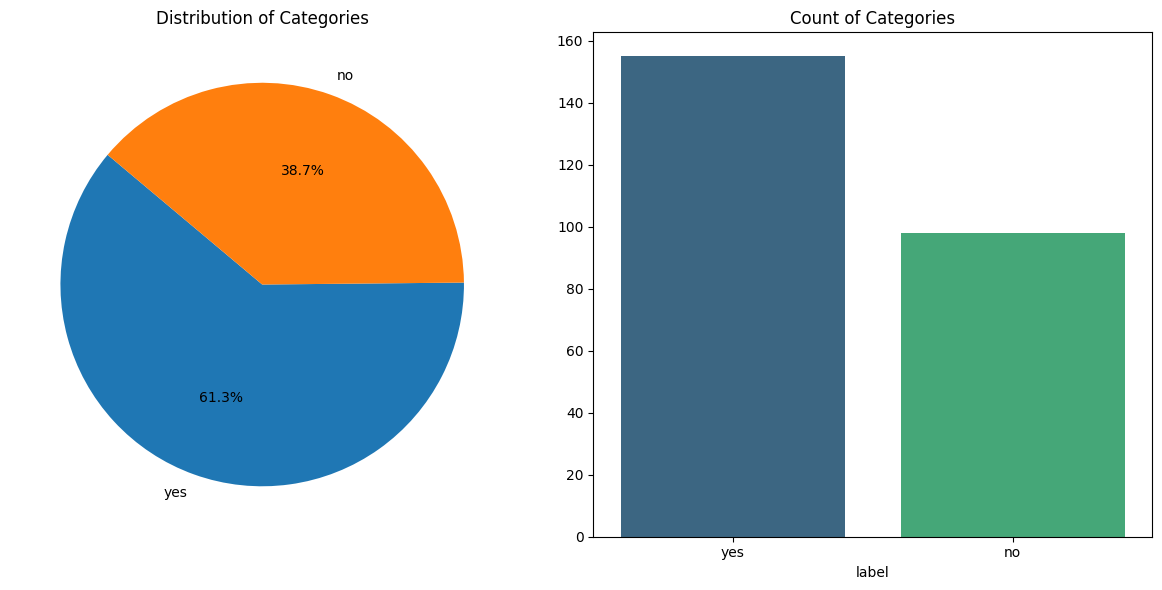

In [9]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

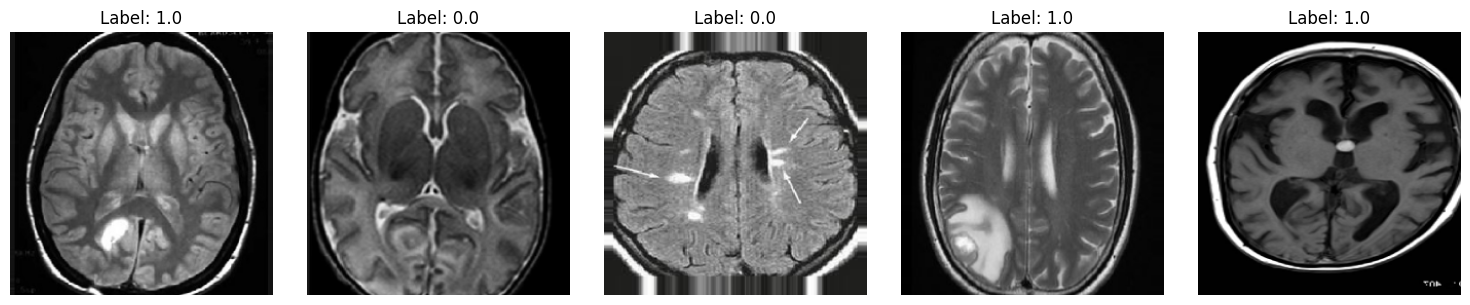

In [10]:
# Function to select and display random images
def display_random_images(generator, num_images):
    # Get batch of images and labels
    batch = next(generator)

    # Select random images from the batch
    selected_indices = random.sample(range(len(batch[0])), min(num_images, len(batch[0])))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, idx in enumerate(selected_indices):
        image = batch[0][idx]  # Get the image array from batch
        label = batch[1][idx]  # Get the corresponding label
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")  # Set label as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Assuming train_generator is your NumpyArrayIterator for the training set
# Display 5 random images from the training set
display_random_images(train_ds, 5)


In [11]:
# Define the class labels for brain tumor classification
class_labels = train_ds.class_indices

# Print the class labels
print(f'Class labels: {class_labels}')


Class labels: {'no': 0, 'yes': 1}


# **IMPORT PRETRAIED MODEL**

In [12]:
from tensorflow.keras.applications import Xception 

# **transfer-learning**

**ResNet50 pre-trained on ImageNet, excluding the top classification layer, with an input shape of 256x256 pixels and 3 channels (RGB).**

In [13]:
conv_base = Xception (
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Define Architecture**

In [14]:
# Build Model
model = Sequential()

# Base Model
model.add(conv_base)

# Add Global Average Pooling to flatten the output from the base model
model.add(GlobalAveragePooling2D())

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [20]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback

# Define a custom tqdm callback that also shows loss and accuracy
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        self.epoch_loss = 0
        self.epoch_accuracy = 0
        self.batches = 0
        self.epoch_progress_bar = tqdm(
            total=self.params['steps'], 
            desc=f"Epoch {epoch+1}/{self.epochs}", 
            unit='batch',
            ncols=100,
            leave=True
        )

    def on_batch_end(self, batch, logs=None):
        batch_loss = logs.get('loss')
        batch_accuracy = logs.get('accuracy')  # or 'acc' depending on your model's compile metrics
        
        if batch_loss is not None:
            self.epoch_loss += batch_loss
        if batch_accuracy is not None:
            self.epoch_accuracy += batch_accuracy
        
        self.batches += 1
        self.epoch_progress_bar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        avg_loss = self.epoch_loss / self.batches
        avg_accuracy = self.epoch_accuracy / self.batches
        
        self.epoch_progress_bar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'Accuracy': f'{avg_accuracy*100:.2f}%'
        })
        self.epoch_progress_bar.close()
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=32,
    validation_data=validation_ds,
    callbacks=[TQDMProgressBar()],
    verbose=0  # Important to avoid clash with tqdm
)




Epoch 1/50:   0%|                                                          | 0/7 [00:00<?, ?batch/s]

Epoch 1/50:  14%|███████▏                                          | 1/7 [00:03<00:20,  3.36s/batch]

Epoch 1/50:  29%|██████████████▎                                   | 2/7 [00:03<00:07,  1.57s/batch]

Epoch 1/50:  43%|█████████████████████▍                            | 3/7 [00:04<00:03,  1.00batch/s]

Epoch 1/50:  57%|████████████████████████████▌                     | 4/7 [00:04<00:02,  1.37batch/s]

Epoch 1/50:  71%|███████████████████████████████████▋              | 5/7 [00:04<00:01,  1.71batch/s]

Epoch 1/50:  86%|██████████████████████████████████████████▊       | 6/7 [00:04<00:00,  2.02batch/s]

Epoch 1/50: 100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  2.70batch/s]

Epoch 1/50: 100%|████████████████████| 7/7 [00:05<00:00,  1.31batch/s, Loss=2.3970, Accuracy=97.32%]


Epoch 2/50:   0%|                                                          | 0/

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy:', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8800 - loss: 0.4193
Test accuracy: 0.8799999952316284


In [22]:
pred = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


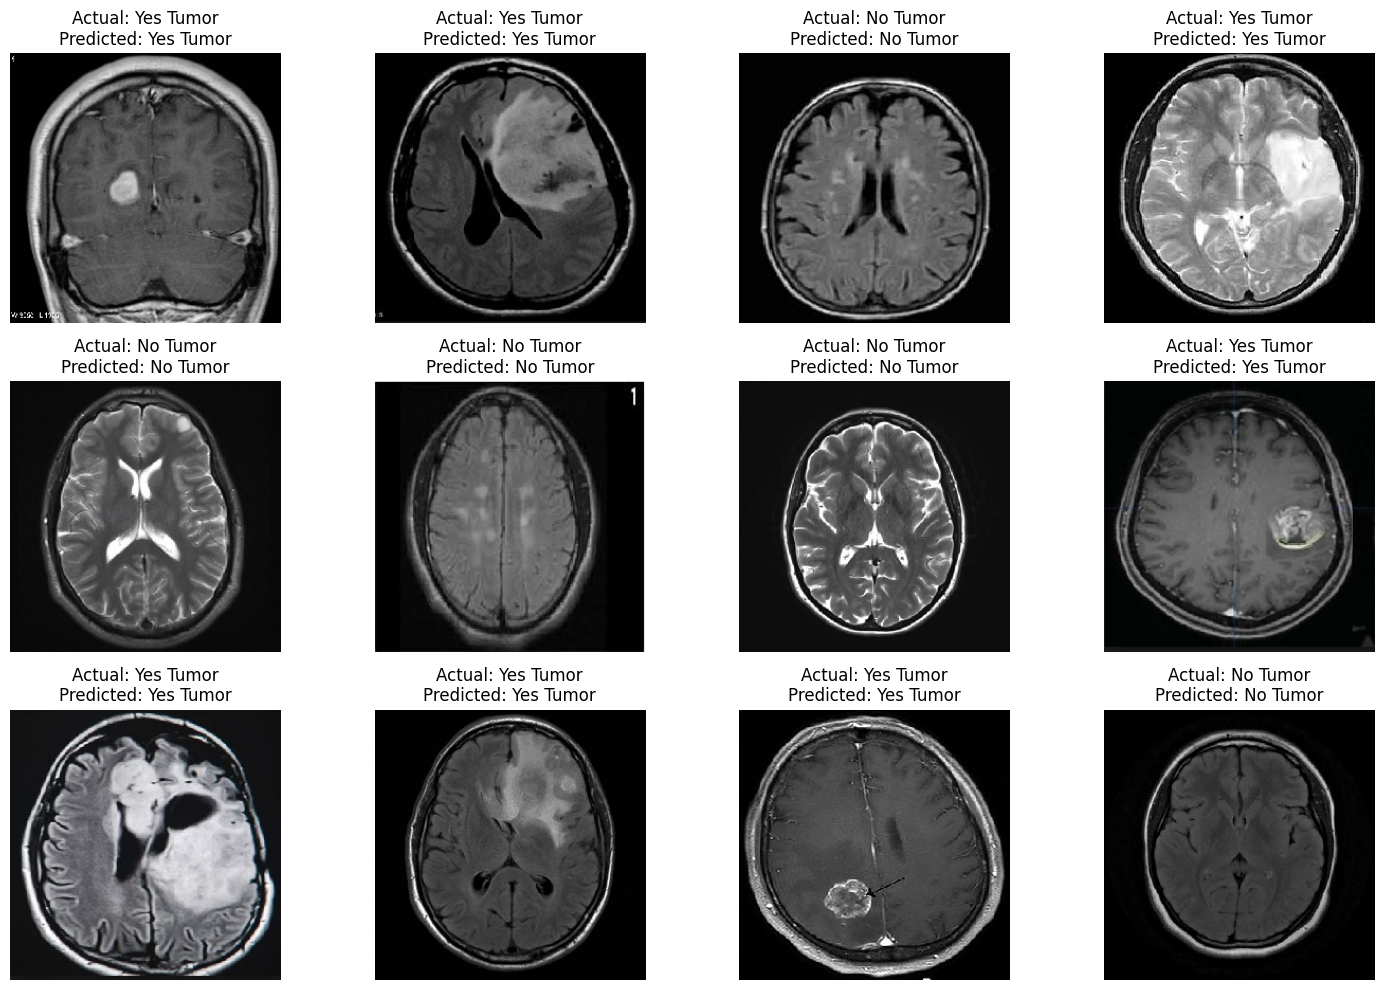

In [23]:
# Fetch a batch of test data from the test dataset generator (test_ds)
x_test, y_test = next(iter(test_ds))
num_images_to_display = 12  # Number of images to display
x_test = x_test[:num_images_to_display]  # Limit to the number of images to display
y_test = y_test[:num_images_to_display]  # Limit to the number of images to display

# Get predictions for the batch of test images
pred = model.predict(x_test)
pred = (pred > 0.5).astype(int).reshape(-1)

# Define class names
classes = ['No Tumor', 'Yes Tumor']

# Number of columns for the subplot grid
num_columns = 4

# Number of rows calculated based on the number of images and columns
num_rows = (num_images_to_display + num_columns - 1) // num_columns

# Plot the images with actual and predicted labels
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(x_test):
        ax.imshow(x_test[i])
        actual_label = classes[int(y_test[i])]  # Convert y_test to int index
        predicted_label = classes[pred[i]]  # Use pred directly as it's already converted
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


# **Plotting the Graph**

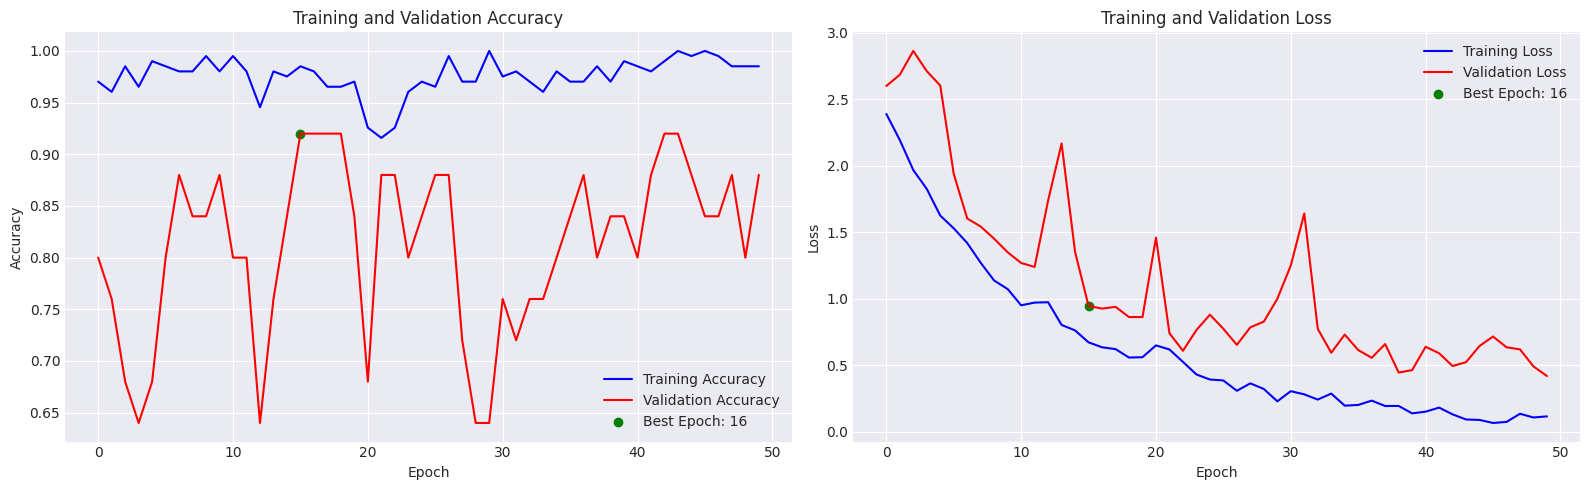

In [24]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [26]:
# Import necessary libraries (already included in your notebook)
import tensorflow as tf
import os

# Assuming 'model' is the trained Keras model
# Replace 'model' with the actual variable name if different

# 1. Save in SavedModel format using model.export()
saved_model_path = '/kaggle/working/brain_tumor_model_savedmodel'
model.export(saved_model_path)  # Use export() for SavedModel
print(f"Model saved in SavedModel format at: {saved_model_path}")

# 2. Save in Keras format (.keras)
keras_model_path = '/kaggle/working/brain_tumor_model.keras'
model.save(keras_model_path)  # Use .keras extension for native Keras format
print(f"Model saved in Keras format at: {keras_model_path}")

# 3. Optional: Save in H5 format (if needed for legacy compatibility)
h5_model_path = '/kaggle/working/brain_tumor_model.h5'
model.save(h5_model_path)  # Use .h5 extension
print(f"Model saved in H5 format at: {h5_model_path}")

# Optional: Verify the saved models by loading them
# For SavedModel
loaded_saved_model = tf.saved_model.load(saved_model_path)
print("SavedModel loaded successfully")

# For Keras (.keras)
loaded_keras_model = tf.keras.models.load_model(keras_model_path)
print("Keras model (.keras) loaded successfully")

# For H5
loaded_h5_model = tf.keras.models.load_model(h5_model_path)
print("H5 model loaded successfully")

Saved artifact at '/kaggle/working/brain_tumor_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135429716291680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596729360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596525344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596889152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596893200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596897424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596896192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596900768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596897600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135429596899184: TensorSpec(shape=(), dtype=tf.resou

Epoch 7/50:   0%|                                                          | 0/7 [20:49<?, ?batch/s]


Model saved in Keras format at: /kaggle/working/brain_tumor_model.keras
Model saved in H5 format at: /kaggle/working/brain_tumor_model.h5
SavedModel loaded successfully
Keras model (.keras) loaded successfully
H5 model loaded successfully


In [27]:
import shutil
import os

# Path to the SavedModel directory
saved_model_path = '/kaggle/working/brain_tumor_model_savedmodel'
# Output zip file path
zip_path = '/kaggle/working/brain_tumor_model_savedmodel.zip'

# Create a zip archive of the SavedModel directory
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', saved_model_path)
print(f"Model zipped at: {zip_path}")

Model zipped at: /kaggle/working/brain_tumor_model_savedmodel.zip


In [29]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# Path to the SavedModel directory
saved_model_path = '/kaggle/working/brain_tumor_model_savedmodel'  # Update to your local path or '/kaggle/working/brain_tumor_model_savedmodel'

# Load the SavedModel
model = tf.saved_model.load(saved_model_path)
print("SavedModel loaded successfully")

# Access the serving function (usually 'serving_default')
infer = model.signatures['serving_default']

# Function to preprocess an image
def preprocess_image(image_path, target_size=(256, 256)):
    # Load image
    img = Image.open(image_path).convert('RGB')  # Ensure RGB format
    # Resize to 256x256
    img = img.resize(target_size)
    # Convert to numpy array
    img_array = np.array(img)
    # Rescale to [0,1]
    img_array = img_array / 255.0
    # Add batch dimension (1, 256, 256, 3)
    img_array = np.expand_dims(img_array, axis=0)
    # Convert to float32
    img_array = img_array.astype(np.float32)
    return img_array

# Function to make predictions
def predict_image(image_path, model_infer, threshold=0.5):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    # Make prediction
    predictions = model_infer(tf.constant(img_array))
    # Get the output (key may vary; check model signature)
    output_key = list(predictions.keys())[0]  # Usually 'dense' or similar
    pred_prob = predictions[output_key].numpy()[0][0]  # Probability for class 1 ("yes")
    # Convert to class label
    pred_class = "yes" if pred_prob >= threshold else "no"
    return pred_prob, pred_class

# Example: Predict on a single image
image_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/21 no.jpg'  # Replace with your image path
prob, label = predict_image(image_path, infer)
print(f"Image: {image_path}")
print(f"Probability of tumor (yes): {prob:.4f}")
print(f"Predicted class: {label}")


SavedModel loaded successfully
Image: /kaggle/input/brain-mri-images-for-brain-tumor-detection/no/21 no.jpg
Probability of tumor (yes): 0.0697
Predicted class: no
